In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import cvxpy as cp
from scipy.stats import poisson, uniform, expon, pareto
from scipy.optimize import minimize, fsolve
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex
from scipy.optimize import least_squares

# simplify for bound

In [479]:
# 1) Declare symbolic variables
x = sp.Symbol('x', real=True)
alpha = sp.Symbol('alpha', positive=True)
n = sp.Symbol('n', positive=True)
C = sp.Symbol('C', positive=True)

# 2) Define the LHS:
#    LHS = [ x^(1/alpha)*(1-x) ] / [ C*((1-x)/(n-1))^(1/alpha)*(1 - (1-x)/(n-1)) ]
lhs_num = x**(1/alpha)*(1 - x)
lhs_den = C * ((1 - x)/(n - 1))**(1/alpha) * (1 - (1 - x)/(n - 1))
lhs = lhs_num / lhs_den

# 3) Define the RHS:
#    RHS = [alpha(1-x) - 1] / [alpha(1 - (1-x)/(n-1)) - 1]
rhs_num = alpha*(1 - x) - 1
rhs_den = alpha*(1 - (1 - x)/(n - 1)) - 1
rhs = rhs_num / rhs_den

# 4) Define the "test" theta = 1 / [1 + (n+2)^(-1/alpha)*(C-1)]
theta = 1 / (1 + (n + 2)**(-1/alpha)*(C - 1))

# 5) Define the test x:
#    x_test = (1/n)*theta + (1 - 1/alpha)*(1 - theta)
x_test = (1/n)*theta + (1 - 1/alpha)*(1 - theta)

# 6) Define expr = LHS - RHS
expr = lhs - rhs
expr

-(alpha*(1 - x) - 1)/(alpha*(-(1 - x)/(n - 1) + 1) - 1) + x**(1/alpha)*(1 - x)/(C*((1 - x)/(n - 1))**(1/alpha)*(-(1 - x)/(n - 1) + 1))

In [480]:
expr_test_sub = expr.subs(x, x_test)
expr_test_sub

-(alpha*(-(1 - 1/alpha)*(1 - 1/((C - 1)/(n + 2)**(1/alpha) + 1)) + 1 - 1/(n*((C - 1)/(n + 2)**(1/alpha) + 1))) - 1)/(alpha*(1 - (-(1 - 1/alpha)*(1 - 1/((C - 1)/(n + 2)**(1/alpha) + 1)) + 1 - 1/(n*((C - 1)/(n + 2)**(1/alpha) + 1)))/(n - 1)) - 1) + ((1 - 1/alpha)*(1 - 1/((C - 1)/(n + 2)**(1/alpha) + 1)) + 1/(n*((C - 1)/(n + 2)**(1/alpha) + 1)))**(1/alpha)*(-(1 - 1/alpha)*(1 - 1/((C - 1)/(n + 2)**(1/alpha) + 1)) + 1 - 1/(n*((C - 1)/(n + 2)**(1/alpha) + 1)))/(C*((-(1 - 1/alpha)*(1 - 1/((C - 1)/(n + 2)**(1/alpha) + 1)) + 1 - 1/(n*((C - 1)/(n + 2)**(1/alpha) + 1)))/(n - 1))**(1/alpha)*(1 - (-(1 - 1/alpha)*(1 - 1/((C - 1)/(n + 2)**(1/alpha) + 1)) + 1 - 1/(n*((C - 1)/(n + 2)**(1/alpha) + 1)))/(n - 1)))

In [499]:
sp.simplify(expr_test_sub.evalf(subs={C:3, alpha:3}))

0.333333333333333*(0.333333333333333 + 0.666666666666667/(1.5874010519682/(0.5*n + 1)**0.333333333333333 + 1.0) - 1/(n*(1.5874010519682/(0.5*n + 1)**0.333333333333333 + 1.0)))*(0.666666666666667 - 0.666666666666667/(1.5874010519682/(0.5*n + 1)**0.333333333333333 + 1.0) + 1/(n*(1.5874010519682/(0.5*n + 1)**0.333333333333333 + 1.0)))**0.333333333333333/(((0.333333333333333 + 0.666666666666667/(1.5874010519682/(0.5*n + 1)**0.333333333333333 + 1.0) - 1/(n*(1.5874010519682/(0.5*n + 1)**0.333333333333333 + 1.0)))/(n - 1.0))**0.333333333333333*(1.0 - (0.333333333333333 + 0.666666666666667/(1.5874010519682/(0.5*n + 1)**0.333333333333333 + 1.0) - 1/(n*(1.5874010519682/(0.5*n + 1)**0.333333333333333 + 1.0)))/(n - 1.0))) - (2.0/(1.5874010519682/(0.5*n + 1)**0.333333333333333 + 1.0) - 3.0/(n*(1.5874010519682/(0.5*n + 1)**0.333333333333333 + 1.0)))/(2.0 - 3.0*(0.333333333333333 + 0.666666666666667/(1.5874010519682/(0.5*n + 1)**0.333333333333333 + 1.0) - 1/(n*(1.5874010519682/(0.5*n + 1)**0.33333333

In [502]:
from sympy.solvers.inequalities import solve_univariate_inequality
solve_univariate_inequality(expr_test_sub.evalf(subs={C:3, alpha:3}) < 0, n)

KeyboardInterrupt: 

In [491]:
alpha_val = 3
n_val     = 2
C_val     = 1.11

expr_num = expr_test_sub.subs({alpha: alpha_val, n: n_val, C: C_val})
print(f"\nNumeric evaluation at alpha={alpha_val}, n={n_val}, C={C_val}:\n", expr_num.evalf())


Numeric evaluation at alpha=3, n=2, C=1.11:
 -0.00295909550082867


In [441]:
# 1) Declare your symbolic variables
alpha, x, n, C = sp.symbols('alpha x n C', positive=True)

# 2) Define the LHS
lhs = ((n - 1)**(1 + 1/alpha)) / (C*(n - 2 + x)) * ((alpha*(1 - x) + 2*x - 1)/alpha)

# 3) Define the RHS
rhs = (alpha*(1 - x) - 1) / (alpha*(1 - (1 - x)/(n - 1)) - 1)

# 4) Look at the difference LHS - RHS and try to simplify
difference = lhs - rhs
simpl_diff = sp.simplify(difference)

print("LHS:", lhs)
print("RHS:", rhs)
print("LHS - RHS =", difference)
print("Simplified difference =", simpl_diff)

LHS: (n - 1)**(1 + 1/alpha)*(alpha*(1 - x) + 2*x - 1)/(C*alpha*(n + x - 2))
RHS: (alpha*(1 - x) - 1)/(alpha*(-(1 - x)/(n - 1) + 1) - 1)
LHS - RHS = -(alpha*(1 - x) - 1)/(alpha*(-(1 - x)/(n - 1) + 1) - 1) + (n - 1)**(1 + 1/alpha)*(alpha*(1 - x) + 2*x - 1)/(C*alpha*(n + x - 2))
Simplified difference = (-C*alpha*(n - 1)*(alpha*(x - 1) + 1)*(n + x - 2) - (n - 1)**((alpha + 1)/alpha)*(alpha*(x - 1) - 2*x + 1)*(alpha*(-n - x + 2) + n - 1))/(C*alpha*(n + x - 2)*(alpha*(-n - x + 2) + n - 1))


In [442]:
lhs

(n - 1)**(1 + 1/alpha)*(alpha*(1 - x) + 2*x - 1)/(C*alpha*(n + x - 2))

In [443]:
rhs

(alpha*(1 - x) - 1)/(alpha*(-(1 - x)/(n - 1) + 1) - 1)

In [444]:
difference

-(alpha*(1 - x) - 1)/(alpha*(-(1 - x)/(n - 1) + 1) - 1) + (n - 1)**(1 + 1/alpha)*(alpha*(1 - x) + 2*x - 1)/(C*alpha*(n + x - 2))

In [445]:
simpl_diff

(-C*alpha*(n - 1)*(alpha*(x - 1) + 1)*(n + x - 2) - (n - 1)**((alpha + 1)/alpha)*(alpha*(x - 1) - 2*x + 1)*(alpha*(-n - x + 2) + n - 1))/(C*alpha*(n + x - 2)*(alpha*(-n - x + 2) + n - 1))

In [446]:
print_latex(simpl_diff)

\frac{- C \alpha \left(n - 1\right) \left(\alpha \left(x - 1\right) + 1\right) \left(n + x - 2\right) - \left(n - 1\right)^{\frac{\alpha + 1}{\alpha}} \left(\alpha \left(x - 1\right) - 2 x + 1\right) \left(\alpha \left(- n - x + 2\right) + n - 1\right)}{C \alpha \left(n + x - 2\right) \left(\alpha \left(- n - x + 2\right) + n - 1\right)}


In [447]:
sp.factor(simpl_diff)

-(n - 1)*(-C*alpha**2*n*x + C*alpha**2*n - C*alpha**2*x**2 + 3*C*alpha**2*x - 2*C*alpha**2 - C*alpha*n - C*alpha*x + 2*C*alpha + alpha**2*n*x*(n - 1)**(1/alpha) - alpha**2*n*(n - 1)**(1/alpha) + alpha**2*x**2*(n - 1)**(1/alpha) - 3*alpha**2*x*(n - 1)**(1/alpha) + 2*alpha**2*(n - 1)**(1/alpha) - 3*alpha*n*x*(n - 1)**(1/alpha) + 2*alpha*n*(n - 1)**(1/alpha) - 2*alpha*x**2*(n - 1)**(1/alpha) + 6*alpha*x*(n - 1)**(1/alpha) - 3*alpha*(n - 1)**(1/alpha) + 2*n*x*(n - 1)**(1/alpha) - n*(n - 1)**(1/alpha) - 2*x*(n - 1)**(1/alpha) + (n - 1)**(1/alpha))/(C*alpha*(n + x - 2)*(alpha*n + alpha*x - 2*alpha - n + 1))

In [448]:
# 5) (Optional) Factor the simplified expression
factored_diff = sp.factor(simpl_diff)
print("Factored difference =", factored_diff)

# 6) (Optional) Solve for x, if you want to see where LHS = RHS
#    (Depending on your domain constraints, you may need to specify them.)
solutions_for_x = sp.solve(sp.Eq(lhs, rhs), x, dict=True)
print("Solutions for x:", solutions_for_x)

Factored difference = -(n - 1)*(-C*alpha**2*n*x + C*alpha**2*n - C*alpha**2*x**2 + 3*C*alpha**2*x - 2*C*alpha**2 - C*alpha*n - C*alpha*x + 2*C*alpha + alpha**2*n*x*(n - 1)**(1/alpha) - alpha**2*n*(n - 1)**(1/alpha) + alpha**2*x**2*(n - 1)**(1/alpha) - 3*alpha**2*x*(n - 1)**(1/alpha) + 2*alpha**2*(n - 1)**(1/alpha) - 3*alpha*n*x*(n - 1)**(1/alpha) + 2*alpha*n*(n - 1)**(1/alpha) - 2*alpha*x**2*(n - 1)**(1/alpha) + 6*alpha*x*(n - 1)**(1/alpha) - 3*alpha*(n - 1)**(1/alpha) + 2*n*x*(n - 1)**(1/alpha) - n*(n - 1)**(1/alpha) - 2*x*(n - 1)**(1/alpha) + (n - 1)**(1/alpha))/(C*alpha*(n + x - 2)*(alpha*n + alpha*x - 2*alpha - n + 1))
Solutions for x: [{x: (-C*alpha**2*n + 3*C*alpha**2 - C*alpha + alpha**2*n*(n - 1)**(1/alpha) - 3*alpha**2*(n - 1)**(1/alpha) - 3*alpha*n*(n - 1)**(1/alpha) + 6*alpha*(n - 1)**(1/alpha) + 2*n*(n - 1)**(1/alpha) - 2*(n - 1)**(1/alpha) - sqrt(C**2*alpha**4*n**2 - 2*C**2*alpha**4*n + C**2*alpha**4 - 2*C**2*alpha**3*n + 2*C**2*alpha**3 + C**2*alpha**2 - 2*C*alpha**4*n**2

In [449]:
solutions_for_x[0][x]

(-C*alpha**2*n + 3*C*alpha**2 - C*alpha + alpha**2*n*(n - 1)**(1/alpha) - 3*alpha**2*(n - 1)**(1/alpha) - 3*alpha*n*(n - 1)**(1/alpha) + 6*alpha*(n - 1)**(1/alpha) + 2*n*(n - 1)**(1/alpha) - 2*(n - 1)**(1/alpha) - sqrt(C**2*alpha**4*n**2 - 2*C**2*alpha**4*n + C**2*alpha**4 - 2*C**2*alpha**3*n + 2*C**2*alpha**3 + C**2*alpha**2 - 2*C*alpha**4*n**2*(n - 1)**(1/alpha) + 4*C*alpha**4*n*(n - 1)**(1/alpha) - 2*C*alpha**4*(n - 1)**(1/alpha) + 6*C*alpha**3*n**2*(n - 1)**(1/alpha) - 12*C*alpha**3*n*(n - 1)**(1/alpha) + 6*C*alpha**3*(n - 1)**(1/alpha) - 4*C*alpha**2*n**2*(n - 1)**(1/alpha) + 10*C*alpha**2*n*(n - 1)**(1/alpha) - 4*C*alpha**2*(n - 1)**(1/alpha) - 4*C*alpha*n*(n - 1)**(1/alpha) + 4*C*alpha*(n - 1)**(1/alpha) + alpha**4*n**2*(n - 1)**(2/alpha) - 2*alpha**4*n*(n - 1)**(2/alpha) + alpha**4*(n - 1)**(2/alpha) - 6*alpha**3*n**2*(n - 1)**(2/alpha) + 14*alpha**3*n*(n - 1)**(2/alpha) - 8*alpha**3*(n - 1)**(2/alpha) + 13*alpha**2*n**2*(n - 1)**(2/alpha) - 32*alpha**2*n*(n - 1)**(2/alpha) + 2

In [454]:
print_latex(solutions_for_x[1][x])

\frac{- C \alpha^{2} n + 3 C \alpha^{2} - C \alpha + \alpha^{2} n \left(n - 1\right)^{\frac{1}{\alpha}} - 3 \alpha^{2} \left(n - 1\right)^{\frac{1}{\alpha}} - 3 \alpha n \left(n - 1\right)^{\frac{1}{\alpha}} + 6 \alpha \left(n - 1\right)^{\frac{1}{\alpha}} + 2 n \left(n - 1\right)^{\frac{1}{\alpha}} - 2 \left(n - 1\right)^{\frac{1}{\alpha}} + \sqrt{C^{2} \alpha^{4} n^{2} - 2 C^{2} \alpha^{4} n + C^{2} \alpha^{4} - 2 C^{2} \alpha^{3} n + 2 C^{2} \alpha^{3} + C^{2} \alpha^{2} - 2 C \alpha^{4} n^{2} \left(n - 1\right)^{\frac{1}{\alpha}} + 4 C \alpha^{4} n \left(n - 1\right)^{\frac{1}{\alpha}} - 2 C \alpha^{4} \left(n - 1\right)^{\frac{1}{\alpha}} + 6 C \alpha^{3} n^{2} \left(n - 1\right)^{\frac{1}{\alpha}} - 12 C \alpha^{3} n \left(n - 1\right)^{\frac{1}{\alpha}} + 6 C \alpha^{3} \left(n - 1\right)^{\frac{1}{\alpha}} - 4 C \alpha^{2} n^{2} \left(n - 1\right)^{\frac{1}{\alpha}} + 10 C \alpha^{2} n \left(n - 1\right)^{\frac{1}{\alpha}} - 4 C \alpha^{2} \left(n - 1\right)^{\frac{1}{\alpha}} 

In [464]:
solutions_for_x[1][x].evalf(subs={alpha:3, n:50, C:5})

0.409585673359069

In [465]:
solutions_for_x[1][x]

(-C*alpha**2*n + 3*C*alpha**2 - C*alpha + alpha**2*n*(n - 1)**(1/alpha) - 3*alpha**2*(n - 1)**(1/alpha) - 3*alpha*n*(n - 1)**(1/alpha) + 6*alpha*(n - 1)**(1/alpha) + 2*n*(n - 1)**(1/alpha) - 2*(n - 1)**(1/alpha) + sqrt(C**2*alpha**4*n**2 - 2*C**2*alpha**4*n + C**2*alpha**4 - 2*C**2*alpha**3*n + 2*C**2*alpha**3 + C**2*alpha**2 - 2*C*alpha**4*n**2*(n - 1)**(1/alpha) + 4*C*alpha**4*n*(n - 1)**(1/alpha) - 2*C*alpha**4*(n - 1)**(1/alpha) + 6*C*alpha**3*n**2*(n - 1)**(1/alpha) - 12*C*alpha**3*n*(n - 1)**(1/alpha) + 6*C*alpha**3*(n - 1)**(1/alpha) - 4*C*alpha**2*n**2*(n - 1)**(1/alpha) + 10*C*alpha**2*n*(n - 1)**(1/alpha) - 4*C*alpha**2*(n - 1)**(1/alpha) - 4*C*alpha*n*(n - 1)**(1/alpha) + 4*C*alpha*(n - 1)**(1/alpha) + alpha**4*n**2*(n - 1)**(2/alpha) - 2*alpha**4*n*(n - 1)**(2/alpha) + alpha**4*(n - 1)**(2/alpha) - 6*alpha**3*n**2*(n - 1)**(2/alpha) + 14*alpha**3*n*(n - 1)**(2/alpha) - 8*alpha**3*(n - 1)**(2/alpha) + 13*alpha**2*n**2*(n - 1)**(2/alpha) - 32*alpha**2*n*(n - 1)**(2/alpha) + 2

In [467]:
theta = sp.symbols('theta', positive=True)
theta

theta

In [469]:
eq = sp.Eq(solutions_for_x[1][x], 1/n*theta + (1-1/alpha)*(1-theta))
eq

Eq((-C*alpha**2*n + 3*C*alpha**2 - C*alpha + alpha**2*n*(n - 1)**(1/alpha) - 3*alpha**2*(n - 1)**(1/alpha) - 3*alpha*n*(n - 1)**(1/alpha) + 6*alpha*(n - 1)**(1/alpha) + 2*n*(n - 1)**(1/alpha) - 2*(n - 1)**(1/alpha) + sqrt(C**2*alpha**4*n**2 - 2*C**2*alpha**4*n + C**2*alpha**4 - 2*C**2*alpha**3*n + 2*C**2*alpha**3 + C**2*alpha**2 - 2*C*alpha**4*n**2*(n - 1)**(1/alpha) + 4*C*alpha**4*n*(n - 1)**(1/alpha) - 2*C*alpha**4*(n - 1)**(1/alpha) + 6*C*alpha**3*n**2*(n - 1)**(1/alpha) - 12*C*alpha**3*n*(n - 1)**(1/alpha) + 6*C*alpha**3*(n - 1)**(1/alpha) - 4*C*alpha**2*n**2*(n - 1)**(1/alpha) + 10*C*alpha**2*n*(n - 1)**(1/alpha) - 4*C*alpha**2*(n - 1)**(1/alpha) - 4*C*alpha*n*(n - 1)**(1/alpha) + 4*C*alpha*(n - 1)**(1/alpha) + alpha**4*n**2*(n - 1)**(2/alpha) - 2*alpha**4*n*(n - 1)**(2/alpha) + alpha**4*(n - 1)**(2/alpha) - 6*alpha**3*n**2*(n - 1)**(2/alpha) + 14*alpha**3*n*(n - 1)**(2/alpha) - 8*alpha**3*(n - 1)**(2/alpha) + 13*alpha**2*n**2*(n - 1)**(2/alpha) - 32*alpha**2*n*(n - 1)**(2/alpha) 

In [473]:
thetas = sp.solve(eq, theta)[0]

In [477]:
sp.simplify(thetas)

n*(-C*alpha**2*n + C*alpha**2 + C*alpha + alpha**2*n*(n - 1)**(1/alpha) - alpha**2*(n - 1)**(1/alpha) - 3*alpha*n*(n - 1)**(1/alpha) + 2*n*(n - 1)**(1/alpha) + 2*(n - 1)**(1/alpha) + sqrt(C**2*alpha**4*n**2 - 2*C**2*alpha**4*n + C**2*alpha**4 - 2*C**2*alpha**3*n + 2*C**2*alpha**3 + C**2*alpha**2 - 2*C*alpha**4*n**2*(n - 1)**(1/alpha) + 4*C*alpha**4*n*(n - 1)**(1/alpha) - 2*C*alpha**4*(n - 1)**(1/alpha) + 6*C*alpha**3*n**2*(n - 1)**(1/alpha) - 12*C*alpha**3*n*(n - 1)**(1/alpha) + 6*C*alpha**3*(n - 1)**(1/alpha) - 4*C*alpha**2*n**2*(n - 1)**(1/alpha) + 10*C*alpha**2*n*(n - 1)**(1/alpha) - 4*C*alpha**2*(n - 1)**(1/alpha) - 4*C*alpha*n*(n - 1)**(1/alpha) + 4*C*alpha*(n - 1)**(1/alpha) + alpha**4*n**2*(n - 1)**(2/alpha) - 2*alpha**4*n*(n - 1)**(2/alpha) + alpha**4*(n - 1)**(2/alpha) - 6*alpha**3*n**2*(n - 1)**(2/alpha) + 14*alpha**3*n*(n - 1)**(2/alpha) - 8*alpha**3*(n - 1)**(2/alpha) + 13*alpha**2*n**2*(n - 1)**(2/alpha) - 32*alpha**2*n*(n - 1)**(2/alpha) + 20*alpha**2*(n - 1)**(2/alpha) -

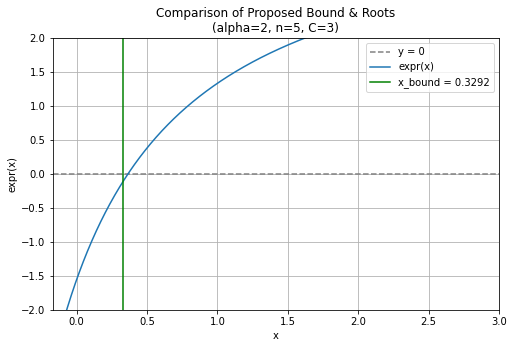

Parameter values: alpha=2, n=5, C=3
Proposed bound x_bound = 0.32915026221291815
Real roots found: []


In [439]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------
# 1) Declare symbolic variables
# --------------------------------------
x = sp.Symbol('x', real=True)
alpha, n, C = sp.symbols('alpha n C', positive=True)

# --------------------------------------
# 2) Define parameters (YOU CAN CHANGE THESE)
# --------------------------------------
alpha_val = 2     # e.g. alpha = 2
n_val     = 5     # e.g. n = 5
C_val     = 3     # e.g. C = 3

# --------------------------------------
# 3) Define the big rational expression
#    We'll call it expr(x). We want to study expr(x) >= 0
# --------------------------------------
# Numerator:
num = (
    - C*alpha*(n - 1)*(alpha*(x - 1) + 1)*(n + x - 2)
    - (n - 1)**((alpha + 1)/alpha)
      * (alpha*(x - 1) - 2*x + 1)
      * (alpha*(-n - x + 2) + (n - 1))
)

# Denominator:
den = C*alpha*(n + x - 2)*(alpha*(-n - x + 2) + (n - 1))

expr = num / den  # The rational function we want >= 0

# --------------------------------------
# 4) Solve expr(x) = 0 symbolically to find roots
# --------------------------------------
solutions = sp.solve(sp.Eq(expr, 0), x, dict=True)

# Extract real solutions in a list
real_roots = []
for sol in solutions:
    sol_x = sol[x]
    if sol_x.is_real:
        real_roots.append(sol_x)

real_roots = list(set(real_roots))  # remove duplicates if any
real_roots.sort()

# --------------------------------------
# 5) Define the proposed lower bound
#    x_bound = (1/n)*theta + (1 - 1/alpha)*(1 - theta)
#    where theta = 1 / (1 + (n+2)^(-1/alpha)*(C-1))
# --------------------------------------
theta = 1 / (1 + (n_val + 2)**(-1/alpha_val)*(C_val - 1))
x_bound = (1/n_val)*theta + (1 - 1/alpha_val)*(1 - theta)

# --------------------------------------
# 6) Numeric/plotting setup
# --------------------------------------
# Turn expr(x) into a numpy-callable function
f_expr = expr.subs({alpha: alpha_val, n: n_val, C: C_val})
f_lam  = sp.lambdify(x, f_expr, 'numpy')

# We'll pick a plotting range that includes the bound & the real roots
left_limit  = min(0, float(x_bound) - 0.5)
right_limit = max(float(x_bound) + 0.5, 3)  # adjust as needed

# Construct a grid for plotting
X_vals = np.linspace(left_limit, right_limit, 1000)
Y_vals = f_lam(X_vals)

# --------------------------------------
# 7) Plot the function
# --------------------------------------
plt.figure(figsize=(8, 5))
plt.axhline(0, color='gray', linestyle='--', label='y = 0')

plt.plot(X_vals, Y_vals, label='expr(x)')

# Vertical line for the bound
plt.axvline(x_bound, color='green', linestyle='-', label=f"x_bound = {x_bound:.4f}")

# Vertical lines for each real root
for r in real_roots:
    r_val = float(r)
    plt.axvline(r_val, color='red', linestyle='--',
                label=f"root ~ {r_val:.4f}")

plt.xlim(left_limit, right_limit)
plt.ylim(-2, 2)  # you can adjust based on expr's typical size

plt.title(f"Comparison of Proposed Bound & Roots\n"
          f"(alpha={alpha_val}, n={n_val}, C={C_val})")
plt.xlabel("x")
plt.ylabel("expr(x)")
plt.legend(loc='best')
plt.grid(True)

plt.show()

# --------------------------------------
# 8) Print results
# --------------------------------------
print(f"Parameter values: alpha={alpha_val}, n={n_val}, C={C_val}")
print(f"Proposed bound x_bound = {x_bound}")
print(f"Real roots found: {real_roots}")


# POA maximization problem

In [330]:
def objective_function(costs, alpha):
    guess = [5*c for c in costs]
    bids = getEquilBids(costs, alpha, guess)
    allos = getAllos(bids, alpha)
    min_cost = np.min(costs)
    poa = np.dot(costs, allos) / min_cost
    return -poa  # Negative for maximization

In [338]:
MAX_COST = 20
alpha    = 3
initial_costs = np.array([1, 2, 2, 2, 2])

In [339]:
bounds = [(1, MAX_COST) for _ in initial_costs]
result = minimize(
    objective_function,
    initial_costs,
    args=(alpha),
    method='L-BFGS-B',
    bounds=bounds,
)

In [340]:
result

      fun: -7.747699496334311
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.69382491, -0.10970344, -0.11751505, -0.09050697, -0.08007407])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 30
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([ 1., 20., 20., 20., 20.])

In [380]:
# checking
alpha = 3.
costs = [1,1,1]
bids = getEquilBids(costs, alpha, guess=[2,5,5])
allos = getAllos(bids, alpha)
poa = np.dot(costs, allos)
bids, allos, poa

(array([2., 2., 2.]), array([0.33333333, 0.33333333, 0.33333333]), 1.0)

In [379]:
alpha = 3.
costs = [1,2,4]
bids = getEquilBids(costs, alpha, guess=[2,4,5])
allos = getAllos(bids, alpha)
poa = np.dot(costs, allos)
bids, allos, poa

(array([3.63494688, 4.16581747, 6.35703569]),
 array([0.5401619 , 0.35885372, 0.10098438]),
 1.6618068601146099)

In [367]:
0.20920884*2*4, 0.20033406*2*5

(1.67367072, 2.0033406)

In [377]:
(0.20033406*2*5-0.20920884*2*4)

0.32966987999999997

In [375]:
0.58158232 - 0.59933188

-0.017749560000000053

# Jensen's

In [381]:
a, x = sp.symbols('a x')
a, x

(a, x)

In [382]:
F = (x**(1/a)*(1-x))/(a-a*x-1)
F

x**(1/a)*(1 - x)/(-a*x + a - 1)

In [383]:
total = 2*(sp.diff(F, x)**2) - (F*sp.diff(sp.diff(F, x), x))
total

-x**(1/a)*(1 - x)*(2*a**2*x**(1/a)*(1 - x)/(-a*x + a - 1)**3 - 2*a*x**(1/a)/(-a*x + a - 1)**2 + 2*x**(1/a)*(1 - x)/(x*(-a*x + a - 1)**2) - 2*x**(1/a)/(a*x*(-a*x + a - 1)) - x**(1/a)*(1 - x)/(a*x**2*(-a*x + a - 1)) + x**(1/a)*(1 - x)/(a**2*x**2*(-a*x + a - 1)))/(-a*x + a - 1) + 2*(a*x**(1/a)*(1 - x)/(-a*x + a - 1)**2 - x**(1/a)/(-a*x + a - 1) + x**(1/a)*(1 - x)/(a*x*(-a*x + a - 1)))**2

In [384]:
total = sp.simplify(total)
total

(-x**((2*a + 1)/a)*(x - 1)*(2*a**4*x**((6*a + 1)/a)*(x - 1) - 2*a**3*x**((6*a + 1)/a)*(a*x - a + 1) + 2*a**2*x**((5*a + 1)/a)*(1 - x)*(a*x - a + 1) + a*x**((4*a + 1)/a)*(1 - x)*(a*x - a + 1)**2 + 2*a*x**((5*a + 1)/a)*(a*x - a + 1)**2 + x**((4*a + 1)/a)*(x - 1)*(a*x - a + 1)**2) + 2*x**(6 + 2/a)*(-a**2*x*(x - 1) + a*x*(a*x - a + 1) + (x - 1)*(a*x - a + 1))**2)/(a**2*x**8*(a*x - a + 1)**4)

In [420]:
total.evalf(subs={a:3, x:0.67})

1280775.80108598

In [ ]:
a, x = sp.symbols('a x')
a, x

F = (a-a*x-1)/(x**(1/a)*(1-x))
F

total = 2*(sp.diff(F, x)**2) - (F*sp.diff(sp.diff(F, x), x))
total

total = sp.simplify(total)
total

total.evalf(subs={a:3, x:0.157})

In [271]:
a, x = sp.symbols('a x')
a, x

(a, x)

In [274]:
F = (a-a*x-1)/(x**(1/a)*(1-x))
F

(-a*x + a - 1)/(x**(1/a)*(1 - x))

In [279]:
total = 2*(sp.diff(F, x)**2) - (F*sp.diff(sp.diff(F, x), x))
total

2*(-a/(x**(1/a)*(1 - x)) + (-a*x + a - 1)/(x**(1/a)*(1 - x)**2) - (-a*x + a - 1)/(a*x*x**(1/a)*(1 - x)))**2 - (-a*x + a - 1)*(-2*a/(x**(1/a)*(1 - x)**2) + 2*(-a*x + a - 1)/(x**(1/a)*(1 - x)**3) + 2/(x*x**(1/a)*(1 - x)) - 2*(-a*x + a - 1)/(a*x*x**(1/a)*(1 - x)**2) + (-a*x + a - 1)/(a*x**2*x**(1/a)*(1 - x)) + (-a*x + a - 1)/(a**2*x**2*x**(1/a)*(1 - x)))/(x**(1/a)*(1 - x))

In [280]:
total = sp.simplify(total)
total

(-x**(2*(a + 3)/a)*(a*x - a + 1)*(-2*a**3*x**((6*a + 5)/a)*(x - 1) - 2*a**2*x**(5*(a + 1)/a)*(x - 1)**2 + 2*a**2*x**((6*a + 5)/a)*(a*x - a + 1) + 2*a*x**(5*(a + 1)/a)*(x - 1)*(a*x - a + 1) + a*x**((4*a + 5)/a)*(x - 1)**2*(a*x - a + 1) + x**((4*a + 5)/a)*(x - 1)**2*(a*x - a + 1)) + 2*x**((6*a + 11)/a)*(-a**2*x*(x - 1) + a*x*(a*x - a + 1) + (x - 1)*(a*x - a + 1))**2)/(a**2*x**((8*a + 13)/a)*(x - 1)**4)

In [291]:
total.evalf(subs={a:3, x:0.157})

-30.2562978621363

In [293]:
x, a, x0 = sp.symbols('x a x0', positive=True, real=True)
# F(x) as defined.
F = (a - a*x - 1) / (x**(1/a)*(1-x))

# Compute first and second derivatives.
Fprime = sp.diff(F, x)
Fdouble = sp.diff(Fprime, x)

# Form the expression that must be nonnegative for convexity.
expr = 2*Fprime**2 - F*Fdouble
expr_simpl = sp.simplify(expr)
print("Expression for convexity condition:")
expr_simpl

Expression for convexity condition:


x**(-2 - 2/a)*(-a**3*x**3 + a**3*x**2 - 3*a**3*x + a**3 + a**2*x**3 - 3*a**2*x**2 + 5*a**2*x - 3*a**2 + 2*a*x**2 - 3*a*x + 3*a + x - 1)/(a**2*(x**3 - 3*x**2 + 3*x - 1))

In [307]:
expr_simpl.evalf(subs={a:2, x:0.2})

50.7812500000000

In [310]:
F = (a - a*x - 1) / (x**(1/a)*(1-x))
sp.simplify(F)

(a*x - a + 1)/(x**(1/a)*(x - 1))

In [311]:
a, x = sp.symbols('a x', positive=True, real=True)

# Define F(x)
F = (a - a*x - 1) / (x**(1/a)*(1-x))

# Compute derivative F'(x)
Fprime = sp.diff(F, x)

# Expression that must be positive for G'(c) > 0:
expr = x + F/Fprime
expr_simpl = sp.simplify(expr)

In [319]:
expr_simpl.evalf(subs={a:3, x:1/4})

-0.166666666666667

In [329]:
x0, c1, a = sp.symbols('x0 c1 a', positive=True, real=True)

# Set parameter a=3
a_val = 3

# Define the function h(x0) so that c1 = h(x0) per the equilibrium condition.
# Note: The equilibrium condition (after algebra) is
#   c1 = ((a*x0 - 1)/(a - a*x0 - 1)) * ((1 - x0)/x0)**(1 - 1/a)
h = ((a*x0 - 1)/(a - a*x0 - 1)) * (((1 - x0)/x0)**(1 - 1/a))

# For a given a, we treat h as a function of x0.
h_sub = h.subs(a, a_val)

# Implicit differentiation: differentiate h(x0) with respect to x0.
dh_dx0 = sp.diff(h_sub, x0)

# Now, x0 is determined by c1 = h(x0). By implicit differentiation,
# dx0/dc1 = 1 / (dh/dx0).
dx0_dc1 = 1 / dh_dx0

# Define phi(c1) = x0, where x0 solves c1 = h(x0).
# Then POA = phi(c1) + c1*(1 - phi(c1)).
x0_phi = sp.symbols('x0_phi', positive=True, real=True)
# We represent POA in terms of phi, but we really want to differentiate with respect to c1.
# Instead, note that by implicit differentiation, we have:
# d(POA)/dc1 = (1 - phi(c1)) + (1 - c1)* (d phi(c1)/dc1).
# For illustration, suppose we fix a value for c1 and compute d(POA)/dc1 numerically.

# Let's choose a sample value for c1 (say, c1 = 2).
c1_val = 3

# Solve h(x0) = c1 for x0.
sol = sp.nsolve(h_sub - c1_val, 0.1)  # initial guess 0.5
phi_val = sol
print("For a =", a_val, "and c1 =", c1_val, "the low cost allocation x0 is:", phi_val)

# Now, compute dx0/dc1 at this solution:
dx0_dc1_val = dx0_dc1.subs(x0, phi_val)
print("dx0/dc1 =", dx0_dc1_val)

# Compute the derivative of POA with respect to c1:
POA = phi_val + c1_val*(1 - phi_val)
# d(POA)/dc1 = (1 - phi_val) + (1 - c1_val)*dx0/dc1
dPOA_dc1 = (1 - phi_val) + (1 - c1_val)*dx0_dc1_val
print("d(POA)/dc1 =", dPOA_dc1)

ValueError: Could not find root within given tolerance. (7.0 > 2.16840434497100886801e-19)
Try another starting point or tweak arguments.

In [149]:
def getEquilBids(cs, a, guess=None):
    n = len(cs)
    bs = [sp.Symbol('b{}'.format(i)) for i in range(n)]
    
    denom = sum([bi**(-a) for bi in bs])
    xs    = [bi**(-a)/denom for bi in bs]
    us    = [(bs[i] - cs[i])*xs[i] for i in range(n)]
    diffs = [sp.diff(us[i], bs[i]) for i in range(n)]
    funcs = [sp.lambdify(bs, diffs[i]) for i in range(n)]
    
    def eqs(bs):
        return [f(*bs) for f in funcs]
    
    initial_guess = cs
    if guess != None:
        initial_guess = guess
    
    return fsolve(eqs, initial_guess)

def getAllos(bids, a):
    denom = sum([b**(-a) for b in bids])
    return np.array(bids**(-a)) / denom

In [150]:
def explicitQuadraticRoot(c, a):
    # Calculate coefficients
    A = (1 - c) * a**2 - 2 * a
    B = c * a * (a - 1) + 2 - a**2
    C = a - 1
    
    # Compute discriminant
    discriminant = B**2 - 4 * A * C
    
    # Compute square root of discriminant
    sqrt_discriminant = math.sqrt(discriminant)
    
    # Compute the positive root using the quadratic formula
    x_star = (-B - sqrt_discriminant) / (2 * A)
    
    return x_star

In [195]:
def getBoundedBids(c, a):
    bigAllo = explicitQuadraticRoot(c=c, a=a)
    b0 = sp.symbols('b0', positive=True, real=True)
    eq = sp.Eq(b0**(-a) / (b0**(-a) + c**(-a)), bigAllo)
    b0_sol = sp.nsolve(eq, c)
    r = b0_sol / c
    B = a / (r*(a-(r**(-a)+1)))
    return B * r, B

In [183]:
alpha = 5
c1s   = np.arange(1, 3.01, 0.1)
c1s

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
       2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ])

In [184]:
guesses = c1s

xTildes  = []
welfares = [] 
bids     = []
for i, c1 in enumerate(c1s):
    costs   = [1, c1]
    cBids   = getEquilBids(costs, a=alpha, guess=[guesses[i],guesses[i]])
    xTilde  = getAllos(cBids, a=alpha)
    xTildes.append(xTilde)
    welfares.append(np.dot(costs, xTilde))
    bids.append(cBids)
xTildes = np.asarray(xTildes)
welfares = np.asarray(welfares)
bids     = np.asarray(bids)
xTildes.shape, welfares.shape, bids.shape

((21, 2), (21,), (21, 2))

In [185]:
boundedBids = np.array([getBoundedBids(c1, alpha) for c1 in c1s]) 
boundedBids.shape

(21, 2)

In [186]:
n = 2
a  = sp.Symbol('a', positive=True)
bs = [sp.Symbol('b{}'.format(i)) for i in range(n)]
cs = [sp.Symbol('c{}'.format(i)) for i in range(n)]
    
denom = sum([bi**(-a) for bi in bs])
xs    = [bi**(-a)/denom for bi in bs]
us    = [(bs[i] - cs[i])*xs[i] for i in range(n)]
focs = [sp.diff(us[i], bs[i]) for i in range(n)]
socs = [sp.diff(focs[i], bs[i]) for i in range(n)]
sp.simplify(socs[0])

a*b1**a*(2*a*b1**(2*a)*(b0 - c0) + 2*b0*b1**a*(b0**a + b1**a) - 2*b0*(b0**a + b1**a)**2 + b1**a*(b0**a + b1**a)*(3*a*(-b0 + c0) - b0 + c0) + (a + 1)*(b0 - c0)*(b0**a + b1**a)**2)/(b0**2*(b0**a + b1**a)**3)

In [187]:
socVals = []
socBounds = []
for i, c1 in enumerate(c1s):
    subs = {
        a:alpha,
        bs[0]:boundedBids[i,0],
        bs[1]:boundedBids[i,1],
        cs[0]:1,
        cs[1]:c1
    }
    soc1 = socs[0].evalf(subs=subs)
    soc2 = socs[1].evalf(subs=subs)
    socBounds.append([soc1, soc2])
    
    subs = {
        a:alpha,
        bs[0]:bids[i,0],
        bs[1]:bids[i,1],
        cs[0]:1,
        cs[1]:c1
    }
    soc1 = socs[0].evalf(subs=subs)
    soc2 = socs[1].evalf(subs=subs)
    socVals.append([soc1, soc2])
socVals = np.asarray(socVals)
socBounds = np.asarray(socBounds)
socVals.shape, socBounds.shape

((21, 2), (21, 2))

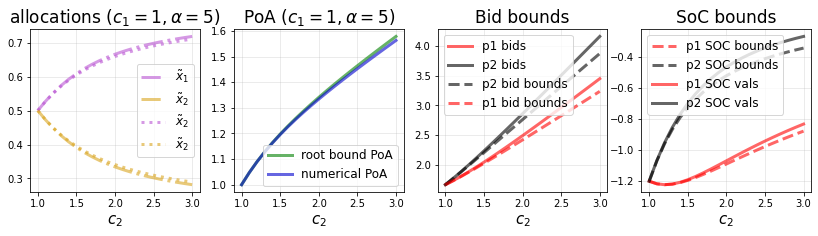

In [188]:
f, axarr = plt.subplots(ncols=4, figsize=(14,3))

axarr[0].plot(c1s, xTildes[:,0], linewidth=3, alpha=0.6, label=r'$\tilde{x}_1$', color='mediumorchid',
              linestyle='-.')
axarr[0].plot(c1s, xTildes[:,1], linewidth=3, alpha=0.6, label=r'$\tilde{x}_2$', color='goldenrod',
              linestyle='-.')
roots = np.array([explicitQuadraticRoot(c1, alpha) for c1 in c1s])
axarr[0].plot(c1s, roots, linewidth=3, alpha=0.6, label=r'$\tilde{x}_2$', color='mediumorchid',
              linestyle='dotted')
axarr[0].plot(c1s, 1-roots, linewidth=3, alpha=0.6, label=r'$\tilde{x}_2$', color='goldenrod',
              linestyle='dotted')



axarr[1].plot(c1s, roots+c1s*(1-roots), linewidth=3, alpha=0.6,
              label='root bound PoA', color='green')
axarr[1].plot(c1s, welfares, linewidth=3, alpha=0.6, label='numerical PoA', color='mediumblue')

axarr[2].plot(c1s, bids[:,0], linewidth=3, alpha=0.6, label='p1 bids', color='red')
axarr[2].plot(c1s, bids[:,1], linewidth=3, alpha=0.6, label='p2 bids', color='black')
axarr[2].plot(c1s, boundedBids[:,1], linewidth=3, alpha=0.6, label='p2 bid bounds', color='black',
              linestyle='--')
axarr[2].plot(c1s, boundedBids[:,0], linewidth=3, alpha=0.6, label='p1 bid bounds', color='red',
              linestyle='--')

axarr[3].plot(c1s, socBounds[:,0], linewidth=3, alpha=0.6, label='p1 SOC bounds', color='red',
              linestyle='--')
axarr[3].plot(c1s, socBounds[:,1], linewidth=3, alpha=0.6, label='p2 SOC bounds', color='black',
              linestyle='--')
axarr[3].plot(c1s, socVals[:,0], linewidth=3, alpha=0.6, label='p1 SOC vals', color='red',
              linestyle='-')
axarr[3].plot(c1s, socVals[:,1], linewidth=3, alpha=0.6, label='p2 SOC vals', color='black',
              linestyle='-')



for ax in axarr:
    ax.grid(alpha=0.3)
    ax.set_xlabel(r'$c_2$', size=15)
    ax.legend(prop={'size': 12})
#     ax.set_xlim(1,2)
axarr[0].set_title(r'allocations $(c_1=1, \alpha={})$'.format(alpha), size=17)
axarr[1].set_title(r'PoA $(c_1=1, \alpha={})$'.format(alpha), size=17)
axarr[2].set_title(r'Bid bounds'.format(alpha), size=17)
axarr[3].set_title(r'SoC bounds'.format(alpha), size=17)


plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [189]:
def explicitRoot2(c, a):
    A = a * ( c*(a-2) - a )
    B = a*(a+1) - c*(a**2 - 4*a + 2)
    C = - ( a + c*(a-1) )
    
    discriminant = B**2 - 4 * A * C
    
    if discriminant < 0:
        sqrt_disc = complex(0, math.sqrt(-discriminant))
    else:
        sqrt_disc = math.sqrt(discriminant)
    
    root1 = (-B + sqrt_disc) / (2 * A)
    root2 = (-B - sqrt_disc) / (2 * A)
    return root1

In [193]:
roots  = np.array([explicitQuadraticRoot(c1, alpha) for c1 in c1s])
roots2 = np.array([explicitRoot2(c1, alpha) for c1 in c1s])

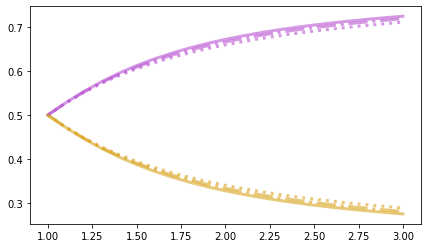

In [194]:
f, ax = plt.subplots(figsize=(7,4))

ax.plot(c1s, xTildes[:,0], linewidth=3, alpha=0.6, label=r'$\tilde{x}_1$', color='mediumorchid',
        linestyle='-.')
ax.plot(c1s, xTildes[:,1], linewidth=3, alpha=0.6, label=r'$\tilde{x}_2$', color='goldenrod',
        linestyle='-.')

ax.plot(c1s, roots, linewidth=3, alpha=0.6, label=r'$\tilde{x}_2$', color='mediumorchid',
              linestyle='dotted')
ax.plot(c1s, 1-roots, linewidth=3, alpha=0.6, label=r'$\tilde{x}_2$', color='goldenrod',
              linestyle='dotted')
ax.plot(c1s, roots2, linewidth=3, alpha=0.6, label=r'$\tilde{x}_2$', color='mediumorchid',
              linestyle='-')
ax.plot(c1s, 1-roots2, linewidth=3, alpha=0.6, label=r'$\tilde{x}_2$', color='goldenrod',
              linestyle='-')

In [196]:
def getBoundedBids2(c, a):
    bigAllo = explicitRoot2(c=c, a=a)
    b0 = sp.symbols('b0', positive=True, real=True)
    eq = sp.Eq(b0**(-a) / (b0**(-a) + c**(-a)), bigAllo)
    b0_sol = sp.nsolve(eq, c)
    r = b0_sol / c
    B = a / (r*(a-(r**(-a)+1)))
    return B * r, B

In [241]:
alpha = 5
c1s   = np.arange(1, 20.01, 0.1)
c1s

array([ 1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,
        2.1,  2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,
        3.2,  3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,
        4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,
        5.4,  5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,
        6.5,  6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,
        7.6,  7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,
        8.7,  8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,
        9.8,  9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8,
       10.9, 11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9,
       12. , 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. ,
       13.1, 13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1,
       14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1, 15.2,
       15.3, 15.4, 15.5, 15.6, 15.7, 15.8, 15.9, 16

In [242]:
guesses = c1s

xTildes  = []
welfares = [] 
bids     = []
for i, c1 in enumerate(c1s):
    costs   = [1, c1]
    cBids   = getEquilBids(costs, a=alpha, guess=[guesses[i],guesses[i]])
    xTilde  = getAllos(cBids, a=alpha)
    xTildes.append(xTilde)
    welfares.append(np.dot(costs, xTilde))
    bids.append(cBids)
xTildes = np.asarray(xTildes)
welfares = np.asarray(welfares)
bids     = np.asarray(bids)
xTildes.shape, welfares.shape, bids.shape

((191, 2), (191,), (191, 2))

In [243]:
roots  = np.array([explicitQuadraticRoot(c1, alpha) for c1 in c1s])
roots2 = np.array([explicitRoot2(c1, alpha) for c1 in c1s])

In [244]:
boundedBids = np.array([getBoundedBids2(c1, alpha) for c1 in c1s]) 
boundedBids.shape

(191, 2)

In [245]:
n = 2
a  = sp.Symbol('a', positive=True)
bs = [sp.Symbol('b{}'.format(i)) for i in range(n)]
cs = [sp.Symbol('c{}'.format(i)) for i in range(n)]
    
denom = sum([bi**(-a) for bi in bs])
xs    = [bi**(-a)/denom for bi in bs]
us    = [(bs[i] - cs[i])*xs[i] for i in range(n)]
focs = [sp.diff(us[i], bs[i]) for i in range(n)]
socs = [sp.diff(focs[i], bs[i]) for i in range(n)]
sp.simplify(socs[0])

a*b1**a*(2*a*b1**(2*a)*(b0 - c0) + 2*b0*b1**a*(b0**a + b1**a) - 2*b0*(b0**a + b1**a)**2 + b1**a*(b0**a + b1**a)*(3*a*(-b0 + c0) - b0 + c0) + (a + 1)*(b0 - c0)*(b0**a + b1**a)**2)/(b0**2*(b0**a + b1**a)**3)

In [246]:
socVals = []
socBounds = []
for i, c1 in enumerate(c1s):
    subs = {
        a:alpha,
        bs[0]:boundedBids[i,0],
        bs[1]:boundedBids[i,1],
        cs[0]:1,
        cs[1]:c1
    }
    soc1 = socs[0].evalf(subs=subs)
    soc2 = socs[1].evalf(subs=subs)
    socBounds.append([soc1, soc2])
    
    subs = {
        a:alpha,
        bs[0]:bids[i,0],
        bs[1]:bids[i,1],
        cs[0]:1,
        cs[1]:c1
    }
    soc1 = socs[0].evalf(subs=subs)
    soc2 = socs[1].evalf(subs=subs)
    socVals.append([soc1, soc2])
socVals = np.asarray(socVals)
socBounds = np.asarray(socBounds)
socVals.shape, socBounds.shape

((191, 2), (191, 2))

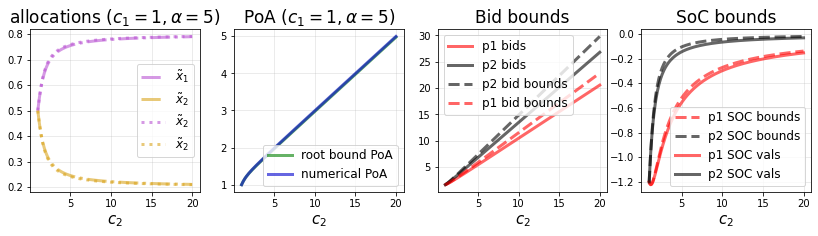

In [247]:
f, axarr = plt.subplots(ncols=4, figsize=(14,3))

axarr[0].plot(c1s, xTildes[:,0], linewidth=3, alpha=0.6, label=r'$\tilde{x}_1$', color='mediumorchid',
              linestyle='-.')
axarr[0].plot(c1s, xTildes[:,1], linewidth=3, alpha=0.6, label=r'$\tilde{x}_2$', color='goldenrod',
              linestyle='-.')
roots = np.array([explicitQuadraticRoot(c1, alpha) for c1 in c1s])
axarr[0].plot(c1s, roots2, linewidth=3, alpha=0.6, label=r'$\tilde{x}_2$', color='mediumorchid',
              linestyle='dotted')
axarr[0].plot(c1s, 1-roots2, linewidth=3, alpha=0.6, label=r'$\tilde{x}_2$', color='goldenrod',
              linestyle='dotted')


axarr[1].plot(c1s, roots2+c1s*(1-roots2), linewidth=3, alpha=0.6,
              label='root bound PoA', color='green')
axarr[1].plot(c1s, welfares, linewidth=3, alpha=0.6, label='numerical PoA', color='mediumblue')

axarr[2].plot(c1s, bids[:,0], linewidth=3, alpha=0.6, label='p1 bids', color='red')
axarr[2].plot(c1s, bids[:,1], linewidth=3, alpha=0.6, label='p2 bids', color='black')
axarr[2].plot(c1s, boundedBids[:,1], linewidth=3, alpha=0.6, label='p2 bid bounds', color='black',
              linestyle='--')
axarr[2].plot(c1s, boundedBids[:,0], linewidth=3, alpha=0.6, label='p1 bid bounds', color='red',
              linestyle='--')

axarr[3].plot(c1s, socBounds[:,0], linewidth=3, alpha=0.6, label='p1 SOC bounds', color='red',
              linestyle='--')
axarr[3].plot(c1s, socBounds[:,1], linewidth=3, alpha=0.6, label='p2 SOC bounds', color='black',
              linestyle='--')
axarr[3].plot(c1s, socVals[:,0], linewidth=3, alpha=0.6, label='p1 SOC vals', color='red',
              linestyle='-')
axarr[3].plot(c1s, socVals[:,1], linewidth=3, alpha=0.6, label='p2 SOC vals', color='black',
              linestyle='-')



for ax in axarr:
    ax.grid(alpha=0.3)
    ax.set_xlabel(r'$c_2$', size=15)
    ax.legend(prop={'size': 12})
#     ax.set_xlim(1,2)
axarr[0].set_title(r'allocations $(c_1=1, \alpha={})$'.format(alpha), size=17)
axarr[1].set_title(r'PoA $(c_1=1, \alpha={})$'.format(alpha), size=17)
axarr[2].set_title(r'Bid bounds'.format(alpha), size=17)
axarr[3].set_title(r'SoC bounds'.format(alpha), size=17)


plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [212]:
# algebraically

In [249]:
a, c, x = sp.symbols('a c x', real=True)
A = a * ( c*(a - 2) - a )
B = a*(a + 1) - c*(a**2 - 4*a + 2)
C = -( a + c*(a - 1) )
discriminant = B**2 - 4 * A * C

root1 = (-B + sp.sqrt(discriminant)) / (2 * A)

root1_simplified = sp.simplify(root1)
root1_simplified

(a*(a + 1) - c*(a**2 - 4*a + 2) - sqrt(4*a*(-a + c*(a - 2))*(a + c*(a - 1)) + (a*(a + 1) - c*(a**2 - 4*a + 2))**2))/(2*a*(a - c*(a - 2)))

In [250]:
b0 = sp.symbols('b0', positive=True, real=True)
eq = sp.Eq(b0**(-a) / (b0**(-a) + c**(-a)), root1_simplified)
eq

Eq(1/(b0**a*(c**(-a) + b0**(-a))), (a*(a + 1) - c*(a**2 - 4*a + 2) - sqrt(4*a*(-a + c*(a - 2))*(a + c*(a - 1)) + (a*(a + 1) - c*(a**2 - 4*a + 2))**2))/(2*a*(a - c*(a - 2))))

In [251]:
sol = sp.solve(eq, (b0))

In [252]:
r = sp.simplify(sol[0] / c)
r

(c**a*(a**2*c - a**2 + a - 2*c - sqrt(a**4*c**2 - 2*a**4*c + a**4 - 4*a**3*c**2 + 6*a**3*c - 2*a**3 + 8*a**2*c**2 + a**2 - 8*a*c**2 - 4*a*c + 4*c**2))/(a**2*c - a**2 - 4*a*c - a + 2*c + sqrt(a**4*c**2 - 2*a**4*c + a**4 - 4*a**3*c**2 + 6*a**3*c - 2*a**3 + 8*a**2*c**2 + a**2 - 8*a*c**2 - 4*a*c + 4*c**2)))**(1/a)/c

In [253]:
B = sp.simplify(a / (r*(a-(r**(-a)+1))))
B

a*c*((-c**a*(-a**2*c + a**2 - a + 2*c + sqrt(a**4*c**2 - 2*a**4*c + a**4 - 4*a**3*c**2 + 6*a**3*c - 2*a**3 + 8*a**2*c**2 + a**2 - 8*a*c**2 - 4*a*c + 4*c**2))/(a**2*c - a**2 - 4*a*c - a + 2*c + sqrt(a**4*c**2 - 2*a**4*c + a**4 - 4*a**3*c**2 + 6*a**3*c - 2*a**3 + 8*a**2*c**2 + a**2 - 8*a*c**2 - 4*a*c + 4*c**2)))**(1/a)/c)**a/((-c**a*(-a**2*c + a**2 - a + 2*c + sqrt(a**4*c**2 - 2*a**4*c + a**4 - 4*a**3*c**2 + 6*a**3*c - 2*a**3 + 8*a**2*c**2 + a**2 - 8*a*c**2 - 4*a*c + 4*c**2))/(a**2*c - a**2 - 4*a*c - a + 2*c + sqrt(a**4*c**2 - 2*a**4*c + a**4 - 4*a**3*c**2 + 6*a**3*c - 2*a**3 + 8*a**2*c**2 + a**2 - 8*a*c**2 - 4*a*c + 4*c**2)))**(1/a)*(((-c**a*(-a**2*c + a**2 - a + 2*c + sqrt(a**4*c**2 - 2*a**4*c + a**4 - 4*a**3*c**2 + 6*a**3*c - 2*a**3 + 8*a**2*c**2 + a**2 - 8*a*c**2 - 4*a*c + 4*c**2))/(a**2*c - a**2 - 4*a*c - a + 2*c + sqrt(a**4*c**2 - 2*a**4*c + a**4 - 4*a**3*c**2 + 6*a**3*c - 2*a**3 + 8*a**2*c**2 + a**2 - 8*a*c**2 - 4*a*c + 4*c**2)))**(1/a)/c)**a*(a - 1) - 1))

In [255]:
(B*r).evalf(subs={a:5, c:5}), B.evalf(subs={a:5, c:5})

(5.86290781312630, 7.37390275192640)

In [24]:
explicitQuadraticRoot(c=5, a=3)

0.6239390754726843

In [79]:
c, a = 5, 3
bigAllo = explicitQuadraticRoot(c=c, a=a)
bigAllo

0.6239390754726843

In [80]:
b0 = sp.symbols('b0', positive=True, real=True)
eq = sp.Eq(b0**(-a) / (b0**(-a) + c**(-a)), bigAllo)
eq

Eq(1/(b0**3*(0.008 + b0**(-3))), 0.623939075472684)

In [83]:
b0_sol = sp.nsolve(eq, c)
b0_sol /5

0.844705537923434

In [131]:
def getBoundedBids(c, a):
    bigAllo = explicitQuadraticRoot(c=c, a=a)
    b0 = sp.symbols('b0', positive=True, real=True)
    eq = sp.Eq(b0**(-a) / (b0**(-a) + c**(-a)), bigAllo)
    b0_sol = sp.nsolve(eq, c)
    r = b0_sol / c
    B = a / (r*(a-(r**(-a)+1)))
    return B * r, B

In [85]:
getBoundedBids(c=5,a=3)

Eq(1/(b0**3*(0.008 + b0**(-3))), 0.623939075472684)


(8.80136029246319, 10.4194419206720)

In [45]:
# given an allo, find the bids that solve the system

In [47]:
a=3

In [64]:
eq = sp.Eq(b0**(-a) / (b0**(-a) + 10**(-a)), 0.6239390754726843)

# Solve the equation with an initial guess (say, 0.8)
b0_sol = sp.nsolve(eq, 10)
print(b0_sol)

8.44705537923434


In [61]:
9.03192/10.71104, 0.844705537923434

(0.8432346438814531, 0.844705537923434)

In [54]:
b0, b1 = sp.Symbol('b0', positive=True), sp.Symbol('b1', positive=True),
eq1 = sp.Eq(b0**(-a) / (b0**(-a) + b1**(-a)), 0.6239390754726843)
eq2 = sp.Eq(b1**(-a) / (b0**(-a) + b1**(-a)), 1-0.6239390754726843)
eq2

Eq(1/(b1**3*(b1**(-3) + b0**(-3))), 0.376060924527316)

In [72]:
b0

a*c0/(a - 1 - 1/r**a)

In [66]:
a, r, c0 = sp.symbols('a r c0', positive=True, real=True)
B = a*c0 / ( r * ( a - (r**(-a) + 1) ) )
b0 = r * B
b1 = B

In [132]:
a_val = 3
r_val = 0.844705537923434
c0_val = 1.0 

B_val = B.subs({a: a_val, r: r_val, c0: c0_val})
b0_val = b0.subs({a: a_val, r: r_val, c0: c0_val})
b1_val = b1.subs({a: a_val, r: r_val, c0: c0_val})
b0_val, b1_val

(b0, 1.18384449385561*a/(a - 1 - 1/0.844705537923434**a))

1. bound low cost allo below and high cost allo above
2. use 2 eq 2 unkowns to solve for equil bids (up to constant)
3. find constant such that it equals the bid when cost is 1.
4. check that bounds are negative in the SOC

In [25]:
def invAllos(x, a):
    return (x/(1-x))**(1/a)

In [44]:
invAllos(0.6239390754726843, a=3)

1.1838444938556116

In [33]:
def socSign(a, b, c, o):
    return (c+b+a*(b-c)) + o*b**a * (c+b+a*(c-b))

In [133]:
c1s

array([ 1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,
        2.1,  2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,
        3.2,  3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,
        4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,
        5.4,  5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,
        6.5,  6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,
        7.6,  7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,
        8.7,  8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,
        9.8,  9.9, 10. ])

In [134]:
p1socs = []
p2socs = []
for i, c1 in enumerate(c1s):
    p1socs.append(socSign(a=3, b=bids[i,0], c=1, o=bids[i,1]**(-3)))
    p2socs.append(socSign(a=3, b=bids[i,1], c=c1, o=bids[i,0]**(-3)))

In [42]:
p2socs

[5.3333333333332344,
 5.802215876041792,
 6.3020472659860305,
 6.826963707824916,
 7.371975865987982,
 7.933012694512142,
 8.506833796633284,
 9.090893467442232,
 9.683202141040876,
 10.282204918595397,
 10.88668256919832,
 11.49567390988246,
 12.10841617298726,
 12.724299647323065,
 13.342833285010839,
 13.963618607323486,
 14.586329840789022,
 15.210698721970019,
 15.83650280522675,
 16.463556407873156,
 17.091703550589898,
 17.720812415830522,
 18.350770968285985,
 18.981483470140297,
 19.612867691428523,
 20.244852660809798,
 20.87737684280903,
 21.51038665095773,
 22.143835228433502,
 22.777681440540896,
 23.411889051691396,
 24.046426010459413,
 24.681263889646814,
 25.316377387182733,
 25.95174391600489,
 26.587343254373675,
 27.223157248214086,
 27.859169556815555,
 28.495365434677954,
 29.131731543797148,
 29.768255791556655]

In [135]:
boundedBids = np.array([getBoundedBids(c1, a) for c1 in c1s]) 
boundedBids.shape

(91, 2)

In [136]:
boundedBids[-1], bids[-1]

(array([16.2753800578079, 19.8553239895231], dtype=object),
 array([16.92147645, 20.67017497]))

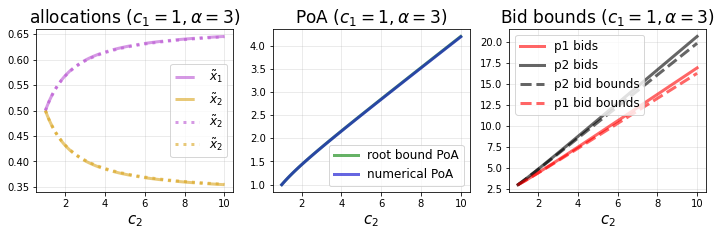

In [137]:
f, axarr = plt.subplots(ncols=3, figsize=(12,3))

axarr[0].plot(c1s, xTildes[:,0], linewidth=3, alpha=0.6, label=r'$\tilde{x}_1$', color='mediumorchid',
              linestyle='-.')
axarr[0].plot(c1s, xTildes[:,1], linewidth=3, alpha=0.6, label=r'$\tilde{x}_2$', color='goldenrod',
              linestyle='-.')
roots = np.array([explicitQuadraticRoot(c1, alpha) for c1 in c1s])
axarr[0].plot(c1s, roots, linewidth=3, alpha=0.6, label=r'$\tilde{x}_2$', color='mediumorchid',
              linestyle='dotted')
axarr[0].plot(c1s, 1-roots, linewidth=3, alpha=0.6, label=r'$\tilde{x}_2$', color='goldenrod',
              linestyle='dotted')



axarr[1].plot(c1s, roots+c1s*(1-roots), linewidth=3, alpha=0.6,
              label='root bound PoA', color='green')
axarr[1].plot(c1s, welfares, linewidth=3, alpha=0.6, label='numerical PoA', color='mediumblue')

axarr[2].plot(c1s, bids[:,0], linewidth=3, alpha=0.6, label='p1 bids', color='red')
axarr[2].plot(c1s, bids[:,1], linewidth=3, alpha=0.6, label='p2 bids', color='black')
axarr[2].plot(c1s, boundedBids[:,1], linewidth=3, alpha=0.6, label='p2 bid bounds', color='black',
              linestyle='--')
axarr[2].plot(c1s, boundedBids[:,0], linewidth=3, alpha=0.6, label='p1 bid bounds', color='red',
              linestyle='--')



for ax in axarr:
    ax.grid(alpha=0.3)
    ax.set_xlabel(r'$c_2$', size=15)
    ax.legend(prop={'size': 12})
#     ax.set_xlim(1,2)
axarr[0].set_title(r'allocations $(c_1=1, \alpha={})$'.format(alpha), size=17)
axarr[1].set_title(r'PoA $(c_1=1, \alpha={})$'.format(alpha), size=17)
axarr[2].set_title(r'Bid bounds $(c_1=1, \alpha={})$'.format(alpha), size=17)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

SOC at the bid bounds.

In [138]:
n = 2
cs = [1,5]
bs = [sp.Symbol('b{}'.format(i)) for i in range(n)]
    
denom = sum([bi**(-a) for bi in bs])
xs    = [bi**(-a)/denom for bi in bs]
us    = [(bs[i] - cs[i])*xs[i] for i in range(n)]
focs = [sp.diff(us[i], bs[i]) for i in range(n)]
socs = [sp.diff(focs[i], bs[i]) for i in range(n)]
socs[0]

-6/(b0**4*(b1**(-3) + b0**(-3))) + 12*(b0 - 1)/(b0**5*(b1**(-3) + b0**(-3))) + 6/(b0**7*(b1**(-3) + b0**(-3))**2) - 30*(b0 - 1)/(b0**8*(b1**(-3) + b0**(-3))**2) + 18*(b0 - 1)/(b0**11*(b1**(-3) + b0**(-3))**3)

In [141]:
focs[0]

1/(b0**3*(b1**(-3) + b0**(-3))) - 3*(b0 - 1)/(b0**4*(b1**(-3) + b0**(-3))) + 3*(b0 - 1)/(b0**7*(b1**(-3) + b0**(-3))**2)

In [118]:
i=1
socs[0].evalf(subs={bs[0]:boundedBids[i,0],bs[1]:boundedBids[i,1]})

-0.325985515047469

In [139]:
socVals = []
socBounds = []
for i in range(len(c1s)):
    soc1 = socs[0].evalf(subs={bs[0]:boundedBids[i,0],bs[1]:boundedBids[i,1]})
    soc2 = socs[1].evalf(subs={bs[0]:boundedBids[i,0],bs[1]:boundedBids[i,1]})
    socBounds.append([soc1, soc2])
    soc1 = socs[0].evalf(subs={bs[0]:bids[i,0],bs[1]:bids[i,1]})
    soc2 = socs[1].evalf(subs={bs[0]:bids[i,0],bs[1]:bids[i,1]})
    socVals.append([soc1, soc2])
socVals = np.asarray(socVals)
socBounds = np.asarray(socBounds)
socVals.shape, socBounds.shape

((91, 2), (91, 2))

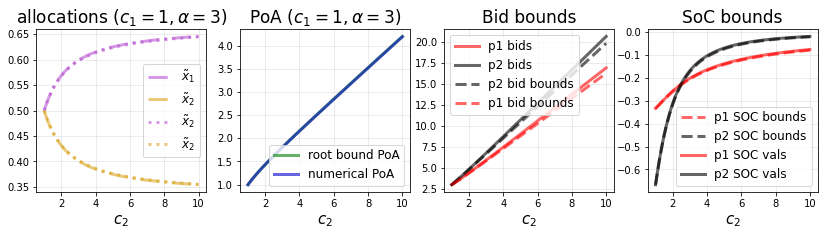

In [140]:
f, axarr = plt.subplots(ncols=4, figsize=(14,3))

axarr[0].plot(c1s, xTildes[:,0], linewidth=3, alpha=0.6, label=r'$\tilde{x}_1$', color='mediumorchid',
              linestyle='-.')
axarr[0].plot(c1s, xTildes[:,1], linewidth=3, alpha=0.6, label=r'$\tilde{x}_2$', color='goldenrod',
              linestyle='-.')
roots = np.array([explicitQuadraticRoot(c1, alpha) for c1 in c1s])
axarr[0].plot(c1s, roots, linewidth=3, alpha=0.6, label=r'$\tilde{x}_2$', color='mediumorchid',
              linestyle='dotted')
axarr[0].plot(c1s, 1-roots, linewidth=3, alpha=0.6, label=r'$\tilde{x}_2$', color='goldenrod',
              linestyle='dotted')



axarr[1].plot(c1s, roots+c1s*(1-roots), linewidth=3, alpha=0.6,
              label='root bound PoA', color='green')
axarr[1].plot(c1s, welfares, linewidth=3, alpha=0.6, label='numerical PoA', color='mediumblue')

axarr[2].plot(c1s, bids[:,0], linewidth=3, alpha=0.6, label='p1 bids', color='red')
axarr[2].plot(c1s, bids[:,1], linewidth=3, alpha=0.6, label='p2 bids', color='black')
axarr[2].plot(c1s, boundedBids[:,1], linewidth=3, alpha=0.6, label='p2 bid bounds', color='black',
              linestyle='--')
axarr[2].plot(c1s, boundedBids[:,0], linewidth=3, alpha=0.6, label='p1 bid bounds', color='red',
              linestyle='--')

axarr[3].plot(c1s, socBounds[:,0], linewidth=3, alpha=0.6, label='p1 SOC bounds', color='red',
              linestyle='--')
axarr[3].plot(c1s, socBounds[:,1], linewidth=3, alpha=0.6, label='p2 SOC bounds', color='black',
              linestyle='--')
axarr[3].plot(c1s, socVals[:,0], linewidth=3, alpha=0.6, label='p1 SOC vals', color='red',
              linestyle='-')
axarr[3].plot(c1s, socVals[:,1], linewidth=3, alpha=0.6, label='p2 SOC vals', color='black',
              linestyle='-')



for ax in axarr:
    ax.grid(alpha=0.3)
    ax.set_xlabel(r'$c_2$', size=15)
    ax.legend(prop={'size': 12})
#     ax.set_xlim(1,2)
axarr[0].set_title(r'allocations $(c_1=1, \alpha={})$'.format(alpha), size=17)
axarr[1].set_title(r'PoA $(c_1=1, \alpha={})$'.format(alpha), size=17)
axarr[2].set_title(r'Bid bounds'.format(alpha), size=17)
axarr[3].set_title(r'SoC bounds'.format(alpha), size=17)


plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()